# PREVENDO O RISCO DE INADIMPLÊNCIA NO CRÉDITO RESIDENCIAL

### MODEL SELECTION AND TUNNING

#### Udacity - Engenheiro de Machine Learning
Vinicius Ferreira Santos - vyniciuss@gmail.com

## HOME CREDIT


### Importando as bibliotecas

In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline
import sys
import pickle
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# ================================================== #
#               Classifiers                          #
# ================================================== #
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
# ================================================== #
#               Scaler and feature selection         #
# ================================================== #
from sklearn.preprocessing import StandardScaler
# ================================================== #
#               Validation and Test                  #
# ================================================== #
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
# ===================================================#
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from time import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


C:\Users\vynic\Anaconda3\envs\py36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## CARREGANDO OS DADOS

In [5]:
#carregando os dados de treinamento
data_train = pd.read_csv("data/application_train_new.csv")
train_ids = data_train['SK_ID_CURR']
train_labels = data_train['TARGET']
features_train = data_train.drop(columns = ['SK_ID_CURR', 'TARGET', 'Unnamed: 0'])
#carregando os dados de teste
data_test = pd.read_csv("data/application_test_new.csv")
test_ids = data_test['SK_ID_CURR']
features_test = data_test.drop(columns = ['SK_ID_CURR', 'Unnamed: 0'])


# Sucesso - Exibindo o primeiro registro treino
display(features_train.head(n=1))

# Sucesso - Exibindo o primeiro registro teste
display(features_test.head(n=1))

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,-0.583687,0.783762,-0.464117,-0.098525,-0.47329,-0.055568,1.50688,0.894907,0.377004,0.579154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,-0.559988,-0.427809,0.142475,-0.553522,-0.037477,-0.164654,-0.733477,-0.483656,-0.056958,1.427241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Separando em dados treino e teste

In [6]:
x_train, x_test, y_train, y_test = train_test_split(features_train, train_labels,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=train_labels)

## Escolha e Afinamento de um Modelo

### Treinar uma variedade de classificadores

Como estou com um problema de natureza superviosionada, usarei os seguintes algorítmos:

- RandonForest: **Obs: randonForest foi utilizada na engenharia de features e obteve um score de 70%**
- Adaboost
- gaussian_nb
- Gradient boosting

In [8]:
classifiers = ['adaboost', 'gaussian_nb', 'gradiend_boosting']

### GaussianNB()

Tempo de ajuste Adabo+ost: 2.272 s


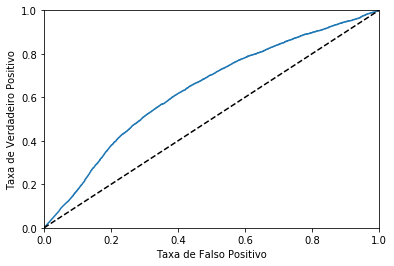

Score Roc: 63.633%


In [43]:
classifier = GaussianNB()
t0 = time()
classifier.fit(x_train, y_train)
print("Tempo de ajuste Adabo+ost:", round(time()-t0, 3), "s")
y_probas = classifier.predict_proba(x_test)
y_scores = y_probas[:, 1] 
draw_roc_score(y_scores, y_test)

### Adaboost

Tempo de ajuste Adabo+ost: 72.778 s


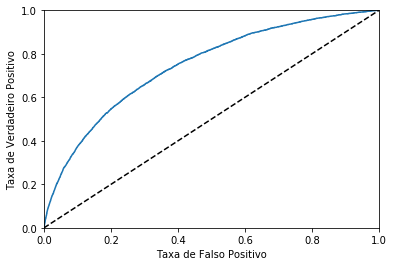

Score Roc: 74.571%


In [44]:
classifier = AdaBoostClassifier()
t0 = time()
classifier.fit(x_train, y_train)
print("Tempo de ajuste Adabo+ost:", round(time()-t0, 3), "s")
y_probas = classifier.predict_proba(x_test)
y_scores = y_probas[:, 1] 
draw_roc_score(y_scores, y_test)

### Gradient Boosting

done in 294.199s


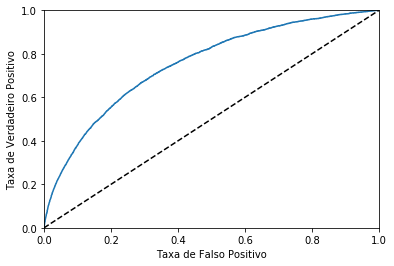

Score Roc: 75.278%


In [45]:
t0 = time()
classifier = GradientBoostingClassifier()
classifier.fit(x_train, y_train)
print("done in %0.3fs" % (time() - t0))
y_probas = classifier.predict_proba(x_test)
y_scores = y_probas[:, 1] 
draw_roc_score(y_scores, y_test)

In [42]:
def draw_roc_score(y_scores, y_test):
    fpr1, tpr1, thresholds = roc_curve(y_test, y_scores)
    plt.plot(fpr1, tpr1, linewidth=1.5, label=None)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.show()

    print("Score Roc: {}%".format(np.round(roc_auc_score(y_test, y_scores)*100, 3)))

### Modelo Selecionado e Tuning

Como pudemos ver na seção anterior, o Gradient Boosting obteve o melhor desempenho utilizando uma instância padrão do classificador, ou seja, sem realizar qualquer ajuste nos seus hiperparâmetros. O proximo passo é identificar o melhor ajuste dos hiperparâmetros para o modelo selecionado, mas aproveitarei a oportunidade para realizar alguns testes nos hiperparâmetros dos outros modelos utilizados para fins de análise. 

In [5]:
def get_classifier_and_param_grid(classifier):
    """Devolve o classificador informado e seu param_grid definido.
    
    Responsável por retornar uma instância do classificador
    especificado e seus parâmetros definidos.
    
    Classificadores definidos: adaboost, random_forest e decision_tree.
    
    Args: 
        classifier: nome do classificador desejado.
        
    Returns:
        return 1: GaussianNB()
        return 2: param_grid
    
    """
    return {
        'adaboost': get_adaboost(),
        'random_forest': get_random_forest_classifier(),
        'decision_tree': get_decision_tree_classifier(),
        'gaussian': get_gaussian_classifier(),
        'knn': get_knn_classifier()
    }.get(classifier)

def get_adaboost():
    """Devolve uma instância do Adaboost e o param_grid definido.
    
    Returns:
        return 1: AdaBoostClassifier()
        return 2: param_grid
    
    """
    decision_tree = []
    for index in range(1, 5):
        decision_tree.append(DecisionTreeClassifier(max_depth=(index), 
                                                    class_weight='balanced',
                                                    min_samples_leaf=2))
    param_grid = {"adaboost__base_estimator": decision_tree,
                  "adaboost__n_estimators": [50],
                  "adaboost__learning_rate": [0.8]
                  }    
    
    return AdaBoostClassifier(), param_grid

def get_random_forest_classifier():
    """Devolve uma instância da RandomForestClassifier e o param_grid definido.
    
    Returns:
        return 1: RandomForestClassifier()
        return 2: param_grid
    
    """
    param_grid = {"random_forest__max_depth": [3, None],
                  "random_forest__max_features": range(1, 5),
                  "random_forest__min_samples_split": [2, 4]
                  }
    
    return RandomForestClassifier(), param_grid

def get_decision_tree_classifier():
    """Devolve uma instância da DecisionTreeClassifier e o param_grid definido.
    
    Returns:
        return 1: DecisionTreeClassifier()
        return 2: param_grid
    
    """
    param_grid = {"decision_tree__max_depth": range(1, 5),
                  "decision_tree__min_samples_leaf": range(1, 5),
                  "decision_tree__min_samples_split": range(2, 5)
                  }
        
    return DecisionTreeClassifier(), param_grid

def get_gaussian_classifier():
    """Devolve uma instância do GaussianNB e o param_grid definido.
    
    Returns:
        return 1: GaussianNB()
        return 2: param_grid
    
    """
    param_grid = {"gaussian__priors": [None]}
        
    return GaussianNB(), param_grid

def get_knn_classifier():
    """Devolve uma instância do KNeighborsClassifier e o param_grid definido.
    
    Returns:
        return 1: KNeighborsClassifier()
        return 2: param_grid
    
    """
    param_grid = {
                  "knn__algorithm": ('auto', 'ball_tree', 'kd_tree', 'brute'),
                  "knn__leaf_size": range(1, 6),
                  "knn__n_neighbors": range(1, 6)
                 }
        
    return KNeighborsClassifier(), param_grid

In [7]:
def build_pipeline(labels, features, classifier_name):
    """ Constrói uma pipeline com GridSearchCV.
    
    Constrói uma pipeline a fim de obter o melhor ajuste 
    para o classificador informado.
    
    Args: 
        labels: labels de treinamento
        features: features de treinamento
        classifier_name: nome do classificador.
        
    Returns:
        GridSearchCV com as informações da melhor configuração.
    
    """
    
    classifier, param_grid = get_classifier_and_param_grid(classifier_name)
    
    pipeline  = Pipeline([
                         ('std_scaler',  StandardScaler()),
                         ('reduce_dim', PCA()),
                         (classifier_name, classifier),
                        ])

    grid_search = GridSearchCV(pipeline, param_grid, scoring = 'roc_auc', cv = 5)

    grid_search.fit(features, labels)

    return grid_search

In [6]:
def performance_classifiers(classifiers_names):
    """ Constrói um dicionário com o melhor ajuste para cada classificador.
    
    Responsável por construir um dicionário com todos os classificadores
    informados como chave e os melhores ajustes encontrado no GridSearch
    como valor.
    
    Args:
        classifiers_names: lista com os nomes dos classificadores.
        
    Returns:
        Dicionário com o nome do classificador como key e o melhor
        ajuste como valor
    
    """
    performance_clasifiers = {}
    for name in classifiers_names:
        performance_clasifiers[name] = build_pipeline(labels_train, features_train, name)
    return performance_clasifiers